In [1]:
import os
import re
import json
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # Should show '12.4' or your installed CUDA version


True
12.1


### Load image

In [18]:
# List all the images in the directory, only show basename
!basename -a /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples/step_7500_sample*


step_7500_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png
step_7500_sample_blue_circle_is_above_blue_square.png
step_7500_sample_blue_square_is_to_the_right_of_red_circle.png
step_7500_sample_blue_triangle_is_above_red_triangle.png
step_7500_sample_blue_triangle_is_to_the_upper_left_of_red_square.png
step_7500_sample_circle_is_below_red_square.png
step_7500_sample_red_circle_is_above_square.png
step_7500_sample_red_circle_is_to_the_left_of_blue_square.png
step_7500_sample_red_is_above_blue.png
step_7500_sample_red_is_to_the_left_of_red.png
step_7500_sample_triangle_is_above_and_to_the_right_of_square.png
step_7500_sample_triangle_is_above_red_circle.png
step_7500_sample_triangle_is_to_the_left_of_square.png
step_7500_sample_triangle_is_to_the_left_of_triangle.png
step_7500_sample_triangle_is_to_the_upper_left_of_square.png


In [ ]:
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


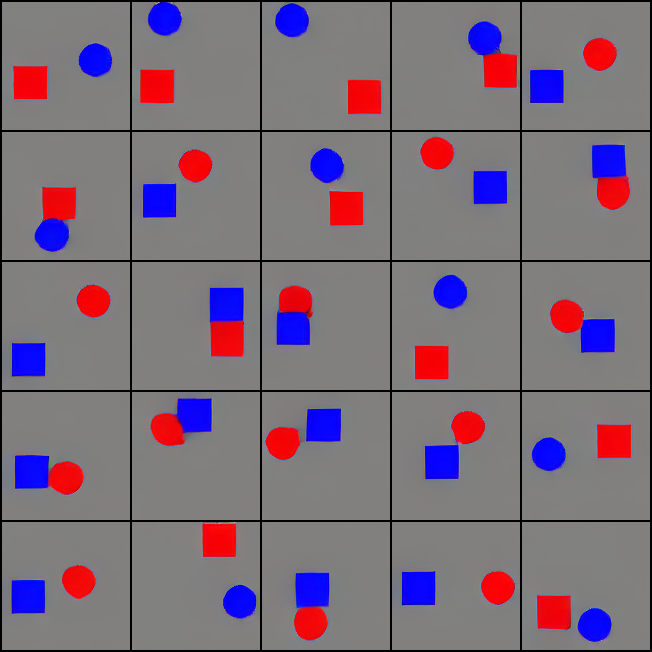

In [60]:
# Load the local image
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]

sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples"

def load_image(step_num, prompt_id, sample_root=sample_root):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=sample_root):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


prompt_id = 2
step_num = 10000
image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
image = Image.open(image_path)
image

In [21]:
# Load the local image
image_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples/step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"
#print(os.path.exists(image_path))
image = Image.open(image_path)

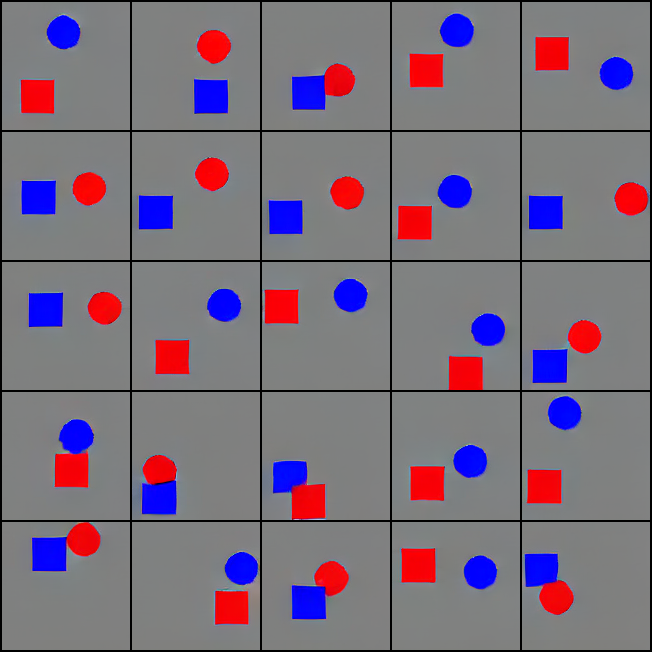

In [4]:
image

In [38]:

# Split image into grid
subimages = split_image_into_grid(image)

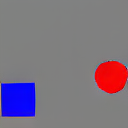

In [49]:
subimages[-10]

In [74]:
import pandas as pd
df = pd.read_csv("/n/home12/binxuwang/Github/DiffusionObjectRelation/notebooks/Complete_Processed_Prompt_Spatial_Relationships.csv")
df#.to_csv("subimages.csv", index=False)
# return each row as a dict
objrect_dicts = df.to_dict(orient="records")


### Process caption

In [7]:
filename = "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"

def extract_object_info(filename):
    """
    Extracts object information from a filename and returns it as a dictionary.

    Args:
    - filename (str): The filename containing object and relationship information.

    Returns:
    - dict: A dictionary with extracted object information.
    """
    # Regular expression to match the pattern in the filename
    pattern = r"sample_(\w+)_([\w_]+)_is_(\w+)_and_(\w+)_of_(\w+)_(\w+).png"
    match = re.search(pattern, filename)
    
    if match:
        # Extract values based on regex groups
        color_1 = match.group(1)
        shape_1 = match.group(2)
        spatial_relationship = f"{match.group(3)}_and_{match.group(4)}"
        color_2 = match.group(5)
        shape_2 = match.group(6)

        # Return as dictionary
        return {
            "shape_1": shape_1,
            "shape_2": shape_2,
            "color_1": color_1,
            "color_2": color_2,
            "spatial_relationship": spatial_relationship
        }
    else:
        raise ValueError("Filename does not match the expected pattern.")

# Example usage
filename = "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"
object_info = extract_object_info(filename)
object_info


{'shape_1': 'circle',
 'shape_2': 'square',
 'color_1': 'blue',
 'color_2': 'blue',
 'spatial_relationship': 'above_and_to_the_right'}

### Load model

In [63]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to("cuda:0")


# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")
# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

processor_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens, patch_size, vision_feature_select_strategy, image_token. 


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


[INST]  
What is shown in this image? [/INST] The image shows a grid with squares that are colored red, blue, and gray. The squares are arranged in a 4x4 pattern, and each row and column contains one square of each color. The red squares are located at the corners of the grid, while the blue squares are placed at the center of each row and column. The gray squares fill the remaining spaces. 


### Construct base questions 

In [75]:
# Initialize your model and processor (assuming LLAVA is being used)
#processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
#model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
#model.to("cuda:0")
# caption guided VQA: "The red triangle is diagonally up and left from the square,"
# Sample questions dictionary with structure for JSON saving
questions_data = {
    # shape count
    "1": {
        "question": "How many shapes are present in the image?",
        "options": ["A. 0", "B. 1", "C. 2", "D. equal to or more than 3"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None
    },
    "2": {
        "question": "How many blobs are present in the image?",
        "options": ["A. 0", "B. 1", "C. 2", "D. equal to or more than 3"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None
    },
    "3": {
        "question": "Are there exactly two distinct shapes in the image?",
        "options": ["A. Yes", "B. No", "C. Not sure"],
        "instructions": "\n Answer only in A, B or C.",
        "reference_answer": "A",
        "model_answer": None,
        "score": None
    },
    # shape types
    "4": {
        "question": "What is the shape that is red in color?",
        "options": ["A. Circle", "B. Square", "C. Triangle", "D. Unidentifiable", "E. No red color shapes"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0" 
    },
    "5": {
        "question": "What is the shape that is blue in color?",
        "options": ["A. Circle", "B. Square", "C. Triangle", "D. Unidentifiable", "E. No blue color shapes"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    # color types 
    "6": {
        "question": "What color is the square in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No square shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    "7": {
        "question": "What color is the circle in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No circle shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "D",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    "8": {
        "question": "What color is the triangle in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No triangle shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    # spatial relations
    "9": {
        "question": "What's the spatial relationship between 2 blobs?",
        "options": ["A. Directly above vs. below", "B. Directly left vs. right", "C. Upper-left vs. Lower-right", "D. Upper-right vs. Lower-left", "E. Overlapping"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None,
        "condition": "shapes question = 2"
    },
    "10": {
        "question": "Where is the red triangle relative to the square?",
        "options": ["A. Up and to the right", "B. Up and to the left", "C. Down and to the right", "D. Down and to the left", "E. Directly above", "F. Directly below", "G. Directly right", "H. Directly left", "I. Overlapping", "J. No triangle identified", "K. No square identified"],
        "instructions": "\n Answer only in A, B, C, D, E, F, G, H or I.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "correctly respond to above questions"
    },
}

# Save initial questions data to a JSON file
with open("questions.json", "w") as f:
    json.dump(questions_data, f, indent=4)


### Update questions based on specific prompt

In [76]:
def update_color_questions(question_data, object_info, target_color):
    """
    Update the reference answer for a question based on the presence of a specific color in the object info.

    Args:
    - question_data (dict): The question data dictionary to modify.
    - object_info (dict): Dictionary containing extracted object information.
    - target_color (str): The target color to check (e.g., 'red', 'blue').

    Returns:
    - None: Modifies question_data in place.
    """
    # Extract shapes and colors from object_info
    color_1 = object_info.get("color_1", "")
    shape_1 = object_info.get("shape_1", "")
    color_2 = object_info.get("color_2", "")
    shape_2 = object_info.get("shape_2", "")

    # Shape to option mapping
    shape_to_option = {
        "circle": "A",
        "square": "B",
        "triangle": "C",
        "unidentifiable": "D"
    }

    # Check for the presence of the target color
    if color_1 == target_color:
        question_data["reference_answer"] = shape_to_option.get(shape_1, "D")
    elif color_2 == target_color:
        question_data["reference_answer"] = shape_to_option.get(shape_2, "D")
    else:
        # Update the reference_answer to E (no shapes with the target color)
        question_data["reference_answer"] = "E"

def update_shape_questions(question_data, object_info, target_shape):
    """
    Update the reference answer for a question based on the target shape's color in the object info.

    Args:
    - question_data (dict): The question data dictionary to modify.
    - object_info (dict): Dictionary containing extracted object information.
    - target_shape (str): The target shape to check (e.g., 'circle', 'square').

    Returns:
    - None: Modifies question_data in place.
    """
    # Extract shapes and colors from object_info
    shape_1 = object_info.get("shape_1", "")
    color_1 = object_info.get("color_1", "")
    shape_2 = object_info.get("shape_2", "")
    color_2 = object_info.get("color_2", "")

    # Check which shape matches the target shape and assign the color
    if shape_1 == target_shape:
        if color_1 == "red":
            question_data["reference_answer"] = "A"  # Red
        elif color_1 == "blue":
            question_data["reference_answer"] = "B"  # Blue
        else:
            question_data["reference_answer"] = "C"  # Not red or blue
    elif shape_2 == target_shape:
        if color_2 == "red":
            question_data["reference_answer"] = "A"  # Red
        elif color_2 == "blue":
            question_data["reference_answer"] = "B"  # Blue
        else:
            question_data["reference_answer"] = "C"  # Not red or blue
    else:
        # No matching shape found
        question_data["reference_answer"] = "D"  # No such shape

# TODO: update relationship questions 


def modify_questions(json_path, object_info):
    """
    Modify the questions_data loaded from a JSON file based on object_info.

    Args:
    - json_path (str): Path to the JSON file containing question details.
    - object_info (dict): Dictionary containing extracted object information.

    Returns:
    - dict: Modified questions_data dictionary.
    """
    # Load the questions data from the JSON file
    with open(json_path, 'r') as file:
        questions_data = json.load(file)

    # Iterate through the questions to modify as needed
    for question_id, question_data in questions_data.items():
        if question_id == "4":  # Modify question 4 based on red shapes
            update_color_questions(question_data, object_info, target_color="red")
        if question_id == "5":  # Modify question 5 based on blue shapes
            update_color_questions(question_data, object_info, target_color="blue")
        if question_id == "6":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="square")
        if question_id == "7":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="circle")
        if question_id == "8":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="triangle")
    with open(json_path, 'w') as file:
        json.dump(questions_data, file, indent=4)
    return questions_data


# Path to the JSON file containing question data
json_path = "questions.json"
object_info = objrect_dicts[1]
# Modify the questions data
try:
    modified_questions = modify_questions(json_path, object_info)
except FileNotFoundError:
    print("The specified JSON file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


In [107]:
processor.tokenizer.eos_token_id

2

In [108]:
# Load and prompt the model with questions, update answers and scores
def ask_model_and_update_json(processor, image, store_path="", file_path="questions.json"):
    # Load questions from JSON
    with open(file_path, "r") as f:
        questions = json.load(f)

    # Iterate over each question and prompt the model
    for q_id, q_data in questions.items():
        question_text = q_data["question"]
        options = q_data["options"]
        instructions = q_data["instructions"]
        reference_answer = q_data["reference_answer"]
        text_input = f"{question_text} Options: {', '.join(options)} {instructions}"
        #print(text_input)
        conversation = [
            {

            "role": "user",
            "content": [
                {"type": "text", "text": text_input},
                {"type": "image"},
                ],
            },
        ]
        # Format the question as a prompt for the model
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

        # Assume we have an image tensor prepared for inference
        # Replace 'image' below with the actual image tensor
        inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")
        
        # Generate model's answer
        output = model.generate(**inputs, max_new_tokens=50, pad_token_id=processor.tokenizer.pad_token_id)
        decoded_output = processor.decode(output[0], skip_special_tokens=True)
        # Extract only the answer by splitting on "[INST]" and taking the last non-empty part
        model_answer = decoded_output.split("[INST]")[-1].strip()

        # If the answer includes extra spaces or text, you can further clean it up
        model_answer = model_answer.split()[-1]  # This assumes the answer is a single letter like "A", "B", "C", or "D"
        
        # Compare model answer to reference answer
        score = 1 if model_answer.strip() == reference_answer else 0
        
        # Update the question data with model answer and score
        questions[q_id]["model_answer"] = model_answer
        questions[q_id]["score"] = score

    # Save updated questions with answers and scores back to JSON
    with open(store_path, "w") as f:
        json.dump(questions, f, indent=4)




In [81]:
from tqdm.auto import trange, tqdm

prompt_id = 1 
step_num = 100000
json_path = "questions.json"
object_info = objrect_dicts[prompt_id]
# Modify the questions data
try:
    modified_questions = modify_questions(json_path, object_info)
except FileNotFoundError:
    print("The specified JSON file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

for step_num in trange(2500, 50001, 2500):
    subimages = load_image_grid(step_num, prompt_id)
    base_store = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/step_{step_num}/"
    for i, subimage in enumerate(tqdm(subimages)):
        # Extract the unique identifier from the subimage path
        unique_name = f"step_{step_num}_sample_{prompt_names[prompt_id]}"
        # Create a new folder under base_store with the unique name
        new_folder_path = os.path.join(base_store, unique_name)
        os.makedirs(new_folder_path, exist_ok=True)
        # Construct the specific JSON store path for the subimage
        store_path = os.path.join(new_folder_path, f"vqa_{i}.json")
        # Assuming `processor` is predefined, and `ask_model_and_update_json` requires the processor, image, and store path
        ask_model_and_update_json(processor, subimage, store_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

  0%|          | 0/25 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [87]:
!echo {base_store}

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/step_50000/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [86]:
!ls {base_store}/../step_10000/step_10000_sample_blue_circle_is_above_blue_square

vqa_0.json   vqa_14.json  vqa_19.json  vqa_23.json  vqa_5.json
vqa_10.json  vqa_15.json  vqa_1.json   vqa_24.json  vqa_6.json
vqa_11.json  vqa_16.json  vqa_20.json  vqa_2.json   vqa_7.json
vqa_12.json  vqa_17.json  vqa_21.json  vqa_3.json   vqa_8.json
vqa_13.json  vqa_18.json  vqa_22.json  vqa_4.json   vqa_9.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [88]:
unique_name

'step_50000_sample_blue_circle_is_above_blue_square'

In [109]:
objrect_dicts[3]

{'shape_1': 'triangle',
 'shape_2': 'triangle',
 'color_1': 'blue',
 'color_2': 'red',
 'spatial_relationship': 'above '}

In [110]:
from tqdm.auto import trange, tqdm

prompt_id = 3
step_num = 100000
json_path = "questions.json"
object_info = objrect_dicts[prompt_id]
# Modify the questions data
try:
    modified_questions = modify_questions(json_path, object_info)
except FileNotFoundError:
    print("The specified JSON file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

for step_num in trange(2500, 50001, 2500):
    subimages = load_image_grid(step_num, prompt_id)
    base_store = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/step_{step_num}/"
    for i, subimage in enumerate(tqdm(subimages)):
        # Extract the unique identifier from the subimage path
        unique_name = f"step_{step_num}_sample_{prompt_names[prompt_id]}"
        # Create a new folder under base_store with the unique name
        new_folder_path = os.path.join(base_store, unique_name)
        os.makedirs(new_folder_path, exist_ok=True)
        # Construct the specific JSON store path for the subimage
        store_path = os.path.join(new_folder_path, f"vqa_{i}.json")
        # Assuming `processor` is predefined, and `ask_model_and_update_json` requires the processor, image, and store path
        ask_model_and_update_json(processor, subimage, store_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [111]:
# load the json file and calculate the average score
import numpy as np
import pandas as pd
base_store = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa"
score_col = []
for step_num in range(2500, 50001, 2500): #os.listdir(base_store):
    # if step_name == "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square":
    step_name = f"step_{step_num}"
    unique_name = f"step_{step_num}_sample_{prompt_names[prompt_id]}"
    # for unique_name in os.listdir(f"{base_store}/{step_name}"):
    scores = []
    for i in range(25):
        vqa_path = f"{base_store}/{step_name}/{unique_name}/vqa_{i}.json"   
        with open(vqa_path, "r") as f:
            vqa = json.load(f)
        scores = np.array([q["score"] for q in vqa.values()])
        score_col.append({"step": step_num, "unique_name": unique_name, 
                            "sample_id": i,
                              "scores": scores, "avg_score": np.mean(scores)})
            
    print(step_name, unique_name, np.mean(scores, axis=0))

score_df = pd.DataFrame(score_col)

step_2500 step_2500_sample_blue_triangle_is_above_red_triangle 0.2
step_5000 step_5000_sample_blue_triangle_is_above_red_triangle 0.3
step_7500 step_7500_sample_blue_triangle_is_above_red_triangle 0.2
step_10000 step_10000_sample_blue_triangle_is_above_red_triangle 0.2
step_12500 step_12500_sample_blue_triangle_is_above_red_triangle 0.2
step_15000 step_15000_sample_blue_triangle_is_above_red_triangle 0.2
step_17500 step_17500_sample_blue_triangle_is_above_red_triangle 0.2
step_20000 step_20000_sample_blue_triangle_is_above_red_triangle 0.2
step_22500 step_22500_sample_blue_triangle_is_above_red_triangle 0.3
step_25000 step_25000_sample_blue_triangle_is_above_red_triangle 0.3
step_27500 step_27500_sample_blue_triangle_is_above_red_triangle 0.2
step_30000 step_30000_sample_blue_triangle_is_above_red_triangle 0.3
step_32500 step_32500_sample_blue_triangle_is_above_red_triangle 0.3
step_35000 step_35000_sample_blue_triangle_is_above_red_triangle 0.2
step_37500 step_37500_sample_blue_triang

blue_triangle_is_above_red_triangle
0 How many shapes are present in the image? C
1 How many blobs are present in the image? C
2 Are there exactly two distinct shapes in the image? A
3 What is the shape that is red in color? C
4 What is the shape that is blue in color? B
5 What color is the square in the image? B
6 What color is the circle in the image? D
7 What color is the triangle in the image? B
8 What's the spatial relationship between 2 blobs? C
9 Where is the red triangle relative to the square? B


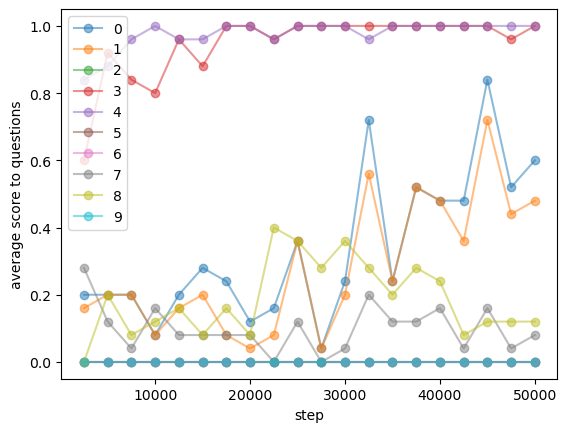

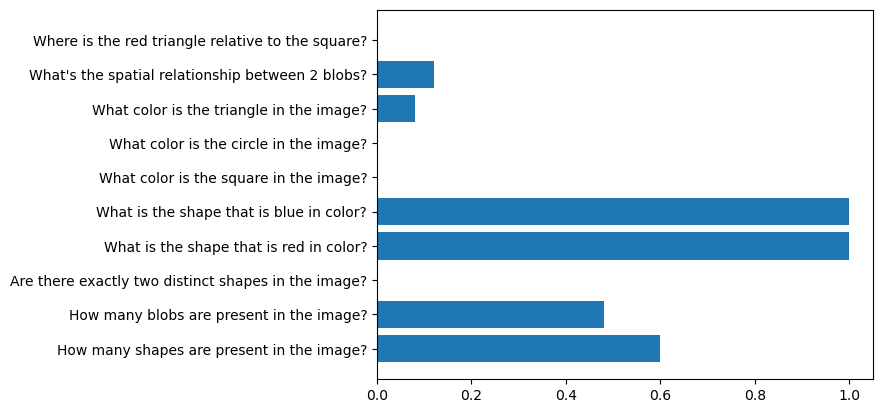

In [136]:
score_data = score_df.groupby(["step", "unique_name"])["scores"].mean()
score_matrix = np.array(score_data.to_list())
step_list = score_df["step"].unique()
print(prompt_names[prompt_id])
for idx, (i, q_data) in enumerate(questions_data.items()):
    print(idx, q_data["question"], q_data["reference_answer"])

plt.plot(step_list, score_matrix, marker="o", label=range(10), alpha=0.5)
plt.legend()
plt.xlabel("step")
plt.ylabel("average score to questions")
plt.show()
# horizontal bar plot
plt.barh(range(10), score_matrix[-1,:]) 
plt.yticks(range(10), [q_data["question"] for q_data in questions_data.values()], rotation=0)
plt.show()

In [114]:
score_df.groupby(["step", "unique_name"])["scores"].mean()

step   unique_name                                          
2500   step_2500_sample_blue_triangle_is_above_red_triangle     [0.2, 0.16, 0.0, 0.6, 0.84, 0.0, 0.0, 0.28, 0....
5000   step_5000_sample_blue_triangle_is_above_red_triangle     [0.2, 0.2, 0.0, 0.92, 0.88, 0.0, 0.0, 0.12, 0....
7500   step_7500_sample_blue_triangle_is_above_red_triangle     [0.2, 0.2, 0.0, 0.84, 0.96, 0.0, 0.0, 0.04, 0....
10000  step_10000_sample_blue_triangle_is_above_red_triangle    [0.08, 0.08, 0.0, 0.8, 1.0, 0.0, 0.0, 0.16, 0....
12500  step_12500_sample_blue_triangle_is_above_red_triangle    [0.2, 0.16, 0.0, 0.96, 0.96, 0.0, 0.0, 0.08, 0...
15000  step_15000_sample_blue_triangle_is_above_red_triangle    [0.28, 0.2, 0.0, 0.88, 0.96, 0.0, 0.0, 0.08, 0...
17500  step_17500_sample_blue_triangle_is_above_red_triangle    [0.24, 0.08, 0.0, 1.0, 1.0, 0.0, 0.0, 0.08, 0....
20000  step_20000_sample_blue_triangle_is_above_red_triangle    [0.12, 0.04, 0.0, 1.0, 1.0, 0.0, 0.0, 0.08, 0....
22500  step_22500_sample_bl

### Collect and quantify results. 

In [101]:
# load the json file and calculate the average score
import numpy as np
import pandas as pd
base_store = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa"
score_col = []
for step_num in range(2500, 50001, 2500): #os.listdir(base_store):
    # if step_name == "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square":
    # continue
    step_name = f"step_{step_num}"
    for unique_name in os.listdir(f"{base_store}/{step_name}"):
        scores = []
        for i in range(25):
            vqa_path = f"{base_store}/{step_name}/{unique_name}/vqa_{i}.json"   
            with open(vqa_path, "r") as f:
                vqa = json.load(f)
            scores = np.array([q["score"] for q in vqa.values()])
            score_col.append({"step": step_num, "unique_name": unique_name, 
                              "sample_id": i,
                              "scores": scores, "avg_score": np.mean(scores)})
            
        print(step_name, unique_name, np.mean(scores, axis=0))

score_df = pd.DataFrame(score_col)

step_2500 step_2500_sample_blue_circle_is_above_blue_square 0.2
step_5000 step_5000_sample_blue_circle_is_above_blue_square 0.0
step_7500 step_7500_sample_blue_circle_is_above_blue_square 0.2
step_10000 step_10000_sample_blue_circle_is_above_blue_square 0.2
step_12500 step_12500_sample_blue_circle_is_above_blue_square 0.2
step_15000 step_15000_sample_blue_circle_is_above_blue_square 0.2
step_17500 step_17500_sample_blue_circle_is_above_blue_square 0.2
step_20000 step_20000_sample_blue_circle_is_above_blue_square 0.3
step_22500 step_22500_sample_blue_circle_is_above_blue_square 0.2
step_25000 step_25000_sample_blue_circle_is_above_blue_square 0.1
step_27500 step_27500_sample_blue_circle_is_above_blue_square 0.3
step_30000 step_30000_sample_blue_circle_is_above_blue_square 0.2
step_32500 step_32500_sample_blue_circle_is_above_blue_square 0.1
step_35000 step_35000_sample_blue_circle_is_above_blue_square 0.2
step_37500 step_37500_sample_blue_circle_is_above_blue_square 0.1
step_40000 step_

In [102]:
score_df.groupby(["step", "unique_name"])["avg_score"].mean()

step   unique_name                                       
2500   step_2500_sample_blue_circle_is_above_blue_square     0.172
5000   step_5000_sample_blue_circle_is_above_blue_square     0.132
7500   step_7500_sample_blue_circle_is_above_blue_square     0.244
10000  step_10000_sample_blue_circle_is_above_blue_square    0.232
12500  step_12500_sample_blue_circle_is_above_blue_square    0.292
15000  step_15000_sample_blue_circle_is_above_blue_square    0.272
17500  step_17500_sample_blue_circle_is_above_blue_square    0.212
20000  step_20000_sample_blue_circle_is_above_blue_square    0.248
22500  step_22500_sample_blue_circle_is_above_blue_square    0.192
25000  step_25000_sample_blue_circle_is_above_blue_square    0.160
27500  step_27500_sample_blue_circle_is_above_blue_square    0.112
30000  step_30000_sample_blue_circle_is_above_blue_square    0.152
32500  step_32500_sample_blue_circle_is_above_blue_square    0.136
35000  step_35000_sample_blue_circle_is_above_blue_square    0.160
3750

In [100]:
object_info

{'shape_1': 'circle',
 'shape_2': 'square',
 'color_1': 'blue',
 'color_2': 'blue',
 'spatial_relationship': 'above '}

In [93]:
vqa

{'1': {'question': 'How many shapes are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'C',
  'score': 1},
 '2': {'question': 'How many blobs are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'B',
  'score': 0},
 '3': {'question': 'Are there exactly two distinct shapes in the image?',
  'options': ['A. Yes', 'B. No', 'C. Not sure'],
  'instructions': '\n Answer only in A, B or C.',
  'reference_answer': 'A',
  'model_answer': 'B',
  'score': 0},
 '4': {'question': 'What is the shape that is red in color?',
  'options': ['A. Circle',
   'B. Square',
   'C. Triangle',
   'D. Unidentifiable',
   'E. No red color shapes'],
  'instructions': '\n Answer only in A, B, C, D or E.',
  'reference_answer': 'E',
 

In [ ]:
base_store = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/"

for i, subimage in enumerate(subimages):
    # Extract the unique identifier from the subimage path
    unique_name = os.path.basename(image_path).replace(".png", "")
    
    # Create a new folder under base_store with the unique name
    new_folder_path = os.path.join(base_store, unique_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Construct the specific JSON store path for the subimage
    store_path = os.path.join(new_folder_path, f"vqa_{i}.json")
    
    # Assuming `processor` is predefined, and `ask_model_and_update_json` requires the processor, image, and store path
    ask_model_and_update_json(processor, subimage, store_path)


In [ ]:
base_store = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/"

for i, subimage in enumerate(subimages):
    # Extract the unique identifier from the subimage path
    unique_name = os.path.basename(image_path).replace(".png", "")
    
    # Create a new folder under base_store with the unique name
    new_folder_path = os.path.join(base_store, unique_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Construct the specific JSON store path for the subimage
    store_path = os.path.join(new_folder_path, f"vqa_{i}.json")
    
    # Assuming `processor` is predefined, and `ask_model_and_update_json` requires the processor, image, and store path
    ask_model_and_update_json(processor, subimage, store_path)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

### Examine VQA response

In [15]:
subimage_id = 0
with open(f"{base_store}vqa_{subimage_id}.json", "r") as f:
    vqa = json.load(f)

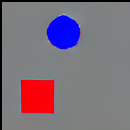

In [17]:
subimages[subimage_id]

In [16]:
vqa

{'1': {'question': 'How many shapes are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'C',
  'score': 1},
 '2': {'question': 'How many blobs are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'C',
  'score': 1},
 '3': {'question': 'Are there exactly two distinct shapes in the image?',
  'options': ['A. Yes', 'B. No', 'C. Not sure'],
  'instructions': '\n Answer only in A, B or C.',
  'reference_answer': 'A',
  'model_answer': 'B',
  'score': 0},
 '4': {'question': 'What is the shape that is red in color?',
  'options': ['A. Circle',
   'B. Square',
   'C. Triangle',
   'D. Unidentifiable',
   'E. No red color shapes'],
  'instructions': '\n Answer only in A, B, C, D or E.',
  'reference_answer': 'E',
 

### Other models

In [ ]:
# Specify the model ID; replace with the desired LLaVA model variant
model_id = "llava-hf/llava-1.5-7b-hf"

# Load the processor and model
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16)
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Load an image from a URL or local path
image_path = "example_QA.jpg"
image = Image.open(image_path)

# Define the text prompt
text_prompt = "Describe the content of the image."

# Prepare the input
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(model.device)

# Generate a response
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=50)

# Decode and print the response
response = processor.batch_decode(outputs, skip_special_tokens=True)[0]
print(response)